In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [2]:
import json

# Turns out descriptionLength, numFollowers, and numStatusesPosted makes the best classification
COLS= (0, 2, 4)

def process_file(file):
    with open(file, "rt", encoding="utf-8") as in_file:
        out = [json.loads(line) for line in in_file]
        # x is array of feature matricies
        # each element of x is array of arrays of 8 user characteristics
        
        # extract user characteristics, leaving behind the tweetedAt timestamp 
        x = np.array([[i[0] for i in j[0]] for j in out], dtype=np.int32).reshape(len(out), 40, 8)
        
        # average the user vectors to produce the "average retweeter"
        x_avg = np.mean(x, axis=1, dtype=np.float64)
        y = np.array([l[2] for l in out], dtype=np.int8)
        
        return x_avg, y
    
def extract_characteristics(data, cols=COLS):
    return np.concatenate(tuple([data[:,i].reshape(-1, 1) for i in cols]), axis=1)
    

x, y = process_file('train_shuffled_final.json')

# we only need descriptionLength and numFollowers to make ~0.7 predictions
x = extract_characteristics(x)

In [3]:
# ccp_alpha and class_weight determined experimentally
model = RandomForestClassifier(ccp_alpha=0.08, n_jobs=8, random_state=100, class_weight='balanced_subsample')

In [4]:
model.fit(x, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.08,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=8, oob_score=False,
                       random_state=100, verbose=0, warm_start=False)

In [5]:
test_x, test_y = process_file('test_shuffled_final.json')
test_x_proba = model.predict_proba(extract_characteristics(test_x))[:,1]
fpr_test, tpr_test, threshold_test = roc_curve(test_y, test_x_proba)
print('roc_auc_score:', roc_auc_score(test_y, test_x_proba))

print(classification_report(test_y, model.predict(extract_characteristics(test_x))))

roc_auc_score: 0.755656108597285
              precision    recall  f1-score   support

           0       0.60      0.69      0.64        13
           1       0.73      0.65      0.69        17

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.68      0.67      0.67        30



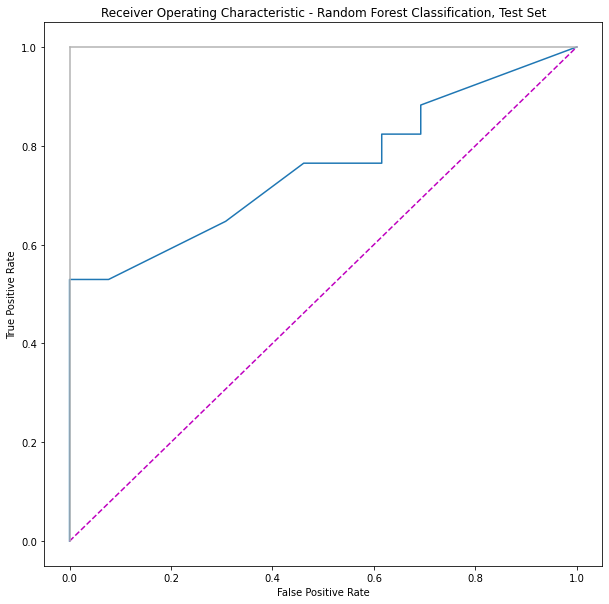

In [6]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest Classification, Test Set')
plt.plot(fpr_test, tpr_test)
plt.plot([0, 1], color="m", ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('test_set_auc.png', dpi=100)
plt.show()

In [7]:
test_x, test_y = process_file('full-dataset-final.json')
test_x_proba = model.predict_proba(extract_characteristics(test_x))[:,1]
fpr_full, tpr_full, threshold_full = roc_curve(test_y, test_x_proba)
print('roc_auc_score:', roc_auc_score(test_y, test_x_proba))

roc_auc_score: 0.7201399300349824


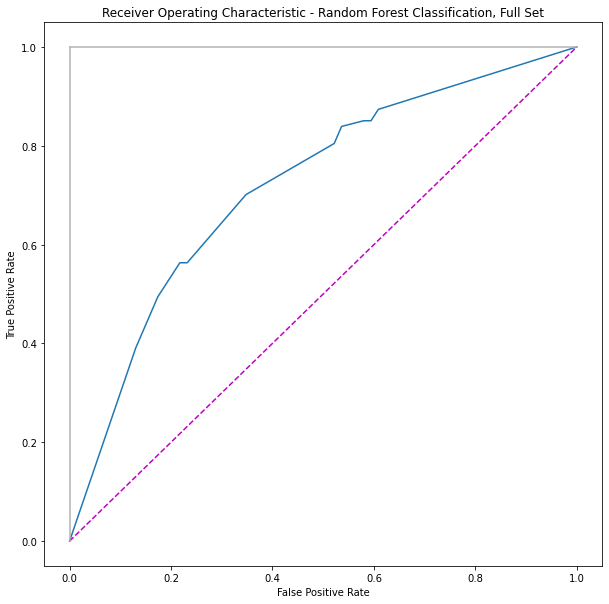

In [8]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest Classification, Full Set')
plt.plot(fpr_full, tpr_full)
plt.plot([0, 1], color="m", ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('full_set_auc.png', dpi=100)
plt.show()